In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [2]:


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter


In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
torch.set_default_device(device)

Using cpu device


In [56]:
# convolution operation formula O=⌊(I−K+2P)/S​⌋+1  (for con)


In [38]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class LeNet(torch.nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = torch.nn.Conv2d(1, 6, 5) #24x24, after maxpool 12
        self.conv2 = torch.nn.Conv2d(6, 16, 3) # 10x10, 5x5
        # an affine operation: y = Wx + b
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16 * 5 * 5)
        #x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [39]:
import matplotlib.pyplot as plt

# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Store separate training and validations splits in ./data
training_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
validation_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

training_loader = torch.utils.data.DataLoader(training_set,
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=2)


validation_loader = torch.utils.data.DataLoader(validation_set,
                                                batch_size=4,
                                                shuffle=False,
                                                num_workers=2)

In [40]:

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

print(training_loader)

In [41]:
# Extract a batch of 4 images
dataiter = iter(training_loader)
images, labels = next(dataiter)

In [42]:
#DO NOT RUN
# Create a grid from the images and show them
#img_grid = torchvision.utils.make_grid(images)
#matplotlib_imshow(img_grid, one_channel=True)

In [43]:
net = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [44]:
print(len(validation_loader))
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(training_loader, 0):
        # basic training loop
        inputs, labels = data
        optimizer.zero_grad()
        #print("input", input)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # Every 1000 mini-batches...
            print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0

            # In evaluation mode some model specific operations can be omitted eg. dropout layer
            net.train(False) # Switching to evaluation mode, eg. turning off regularisation
            for j, vdata in enumerate(validation_loader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True) # Switching back to training mode, eg. turning on regularisation

            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validation_loader)

            running_loss = 0.0
print('Finished Training')


2500
Batch 1000
Batch 2000
Batch 3000
Batch 4000
Batch 5000
Batch 6000
Batch 7000
Batch 8000
Batch 9000
Batch 10000
Batch 11000
Batch 12000
Batch 13000
Batch 14000
Batch 15000
Finished Training


In [45]:
dataiter = iter(training_loader)
images, labels = next(dataiter)

from IPython.display import display
# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
#matplotlib_imshow(img_grid, one_channel=True)

display(img_grid)

tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0., -1.,  ..., -1.,  0.,  0.],
         ...,
         [ 0.,  0., -1.,  ..., -1.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0., -1.,  ..., -1.,  0.,  0.],
         ...,
         [ 0.,  0., -1.,  ..., -1.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0., -1.,  ..., -1.,  0.,  0.],
         ...,
         [ 0.,  0., -1.,  ..., -1.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]])

In [46]:
img_grid2 = torchvision.utils.make_grid(images[3])
#matplotlib_imshow(img_grid2, one_channel=True)
print(classes[labels[3]])

Ankle Boot


In [47]:
indx = net(images[3])
print(classes[torch.argmax(indx)])

Ankle Boot


In [48]:
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [49]:
print(net.conv1)
print(net.conv1.weight)
print(net.conv1.weight.shape)

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
Parameter containing:
tensor([[[[-0.5040, -0.3104, -0.4009, -0.2951, -0.1669],
          [-0.3764, -0.6185, -0.6212, -0.2795, -0.0783],
          [-0.0577, -0.1840, -0.1338,  0.0039,  0.0917],
          [ 0.2458, -0.0688,  0.1838,  0.1095,  0.1703],
          [ 0.2684, -0.0021,  0.1973,  0.2465,  0.1360]]],


        [[[-0.1942,  0.2957,  0.3650,  0.1969,  0.3218],
          [ 0.1792,  0.0471,  0.0502, -0.0334, -0.1432],
          [ 0.1445,  0.0425, -0.0767, -0.1335,  0.0799],
          [-0.0101,  0.0519, -0.0469,  0.0504, -0.0306],
          [-0.1462, -0.2293, -0.2914, -0.2865, -0.1246]]],


        [[[-0.1073, -0.1807, -0.1926, -0.2274,  0.2901],
          [-0.3740, -0.4003,  0.0717, -0.1538,  0.3227],
          [-0.0008, -0.2408,  0.0440,  0.0768,  0.2012],
          [-0.2201, -0.0398, -0.0727,  0.3212,  0.3981],
          [-0.0177,  0.0178,  0.2314,  0.1214,  0.2677]]],


        [[[-0.0067,  0.1685,  0.0297,  0.1846, -0.0767],
      

In [50]:
print(net.conv1.weight[0][0])

tensor([[-0.5040, -0.3104, -0.4009, -0.2951, -0.1669],
        [-0.3764, -0.6185, -0.6212, -0.2795, -0.0783],
        [-0.0577, -0.1840, -0.1338,  0.0039,  0.0917],
        [ 0.2458, -0.0688,  0.1838,  0.1095,  0.1703],
        [ 0.2684, -0.0021,  0.1973,  0.2465,  0.1360]],
       grad_fn=<SelectBackward0>)


In [51]:
tf0 = net.conv1.weight[0][0].detach().numpy()
print(tf0)

[[-0.5039643  -0.31044683 -0.40089077 -0.29508802 -0.16689646]
 [-0.37641346 -0.6185268  -0.62124586 -0.2794657  -0.07834861]
 [-0.05772603 -0.18399888 -0.13376953  0.00390571  0.09167274]
 [ 0.24577725 -0.06877641  0.18376374  0.10946047  0.1702796 ]
 [ 0.26841173 -0.00210854  0.19733192  0.24648032  0.13596243]]


In [52]:
tff = net.conv1.weight[5][0].detach()
print(tff)

tensor([[-0.1857, -0.2534,  0.3963,  0.3401, -0.0096],
        [-0.4615, -0.4510,  0.5456,  0.2862,  0.0851],
        [-0.3552, -0.3655,  0.2596,  0.2203,  0.0350],
        [-0.0318, -0.3280,  0.3286,  0.0960, -0.1022],
        [-0.1580, -0.2219,  0.1206,  0.2103, -0.0060]])


In [53]:
print(net.conv2)
print(net.conv2.weight)
print(net.conv2.weight.shape)

Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
Parameter containing:
tensor([[[[ 6.0449e-02, -5.5190e-02, -1.0121e-01],
          [-1.6806e-01, -4.8105e-02,  4.6673e-02],
          [-6.2283e-02, -1.3487e-01, -9.9181e-02]],

         [[-3.6041e-02, -1.2216e-01,  3.8536e-02],
          [ 1.1365e-01, -5.7495e-02, -1.1301e-01],
          [-8.4285e-02, -1.4652e-02,  1.3766e-01]],

         [[-8.7762e-02,  3.1852e-02, -8.1761e-02],
          [-1.0090e-01,  4.7788e-02, -1.1730e-01],
          [-1.4523e-02,  5.9967e-02, -2.6949e-02]],

         [[ 1.4978e-01, -4.5599e-02, -1.4681e-02],
          [ 1.4995e-01,  8.0956e-02,  1.1051e-01],
          [ 1.4233e-01,  8.3091e-02,  8.3277e-02]],

         [[-3.6055e-02, -6.2020e-02, -2.8929e-02],
          [-5.0865e-02, -7.6905e-02, -3.0697e-02],
          [-8.5860e-02,  1.0987e-01, -1.1036e-01]],

         [[ 1.4304e-01,  7.6230e-02,  3.5542e-02],
          [-3.6678e-03,  1.1709e-01,  9.3801e-02],
          [ 4.4509e-02, -1.8508e-02, -6.8919e-02]]],

[[ 81.43251   74.659676 139.63026  134.01378   99.04334 ]
 [ 53.85189   54.900776 154.55606  128.6199   108.512184]
 [ 64.47924   63.45128  125.958374 122.0278   103.50405 ]
 [ 96.8179    67.19829  132.86276  109.600975  89.77836 ]
 [ 84.204     77.81126  112.05864  121.025406  99.40432 ]]
[[ 81  74 139 134  99]
 [ 53  54 154 128 108]
 [ 64  63 125 122 103]
 [ 96  67 132 109  89]
 [ 84  77 112 121  99]]


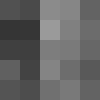

In [54]:
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
tff = net.conv1.weight[5][0].detach()
tff1 = ((tff + 1)*100).numpy()
print(tff1)
tff11 = tff1.astype(np.uint8)
print(tff11)

img = Image.fromarray(tff11, "L")
img2 = img.resize((100,100), resample=Image.BOX)
display(img2) 

[[ 98.9813   122.28496  128.51285 ]
 [106.30476  124.57731  117.331184]
 [ 92.85202  123.94136  113.15464 ]]
[[ 98 122 128]
 [106 124 117]
 [ 92 123 113]]


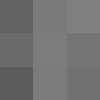

In [55]:
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
tff = net.conv2.weight[5][0].detach()
tff1 = ((tff + 1)*100).numpy()
print(tff1)
tff11 = tff1.astype(np.uint8)
print(tff11)

img = Image.fromarray(tff11, "L")
img2 = img.resize((100,100), resample=Image.BOX)
display(img2) 